In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Charger les données
df = pd.read_csv(r"C:\Users\MSI\Desktop\Attijari_bank\transactions_attijari_bank.csv")
# Prétraitement (heure → nombre + encodage du type)
df['heure_num'] = df['heure'].str.split(':').apply(lambda x: int(x[0]) + int(x[1])/60)
df['type_tx_encoded'] = pd.factorize(df['type_transaction'])[0]

# Sélectionner les colonnes utiles
features = ['montant', 'frequence', 'solde_avant', 'solde_après', 'heure_num', 'type_tx_encoded']
X = df[features]

# Normaliser
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_dim = X_scaled.shape[1]

# Architecture Autoencoder
model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(4, activation='relu'),
    layers.Dense(2, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

model.compile(optimizer='adam', loss='mse')

# Entraînement
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)
model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), verbose=0)



In [9]:
import numpy as np

# Prédictions reconstruites
X_pred = model.predict(X_scaled)

# Calcul des erreurs MSE ligne par ligne
mse = np.mean(np.square(X_scaled - X_pred), axis=1)

# Ajouter les erreurs dans le DataFrame
df['reconstruction_error'] = mse


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [11]:
# Définir un seuil (à ajuster)
threshold = np.percentile(mse, 95)  # top 5% comme anomalies

df['is_anomaly'] = df['reconstruction_error'] > threshold


In [13]:
print("Nombre d'anomalies détectées :", df['is_anomaly'].sum())
print(df[df['is_anomaly'] == True].head())


Nombre d'anomalies détectées : 100
                          transaction_id client_id   sexe  age ville_client  \
1   b6815a98-b83b-4862-a8a1-82f755f04b57    CL1023  Homme   47         Sfax   
4   74ffa69c-71c6-46a7-9a79-a937379721f7    CL1004  Femme   26        Tunis   
42  397c0407-c89e-4195-bd45-f8a01caf8b2e    CL1006  Femme   36     Monastir   
54  aaabd6e2-2332-4f84-b555-06908d7d5218    CL1017  Femme   40     Kairouan   
62  3c084b20-71e0-4844-bed2-f37557d18014    CL1060  Homme   46        Gabès   

   pays_client  montant  frequence      lieu     pays  heure  \
1      Tunisie  3054.90          7  Kairouan  Tunisie  02:09   
4      Tunisie    20.00         58     Tunis  Tunisie  19:05   
42     Tunisie   952.90         60  Kairouan  Tunisie  22:29   
54     Tunisie   770.16         56      Sfax  Tunisie  01:53   
62     Tunisie    20.00         12     Tunis  Tunisie  01:24   

    type_transaction                   bénéficiaire  solde_avant  solde_après  \
1           virement    

In [15]:
df.to_csv(r"C:\Users\MSI\Desktop\Attijari_bank\transactions_fraudes.csv", index=False)


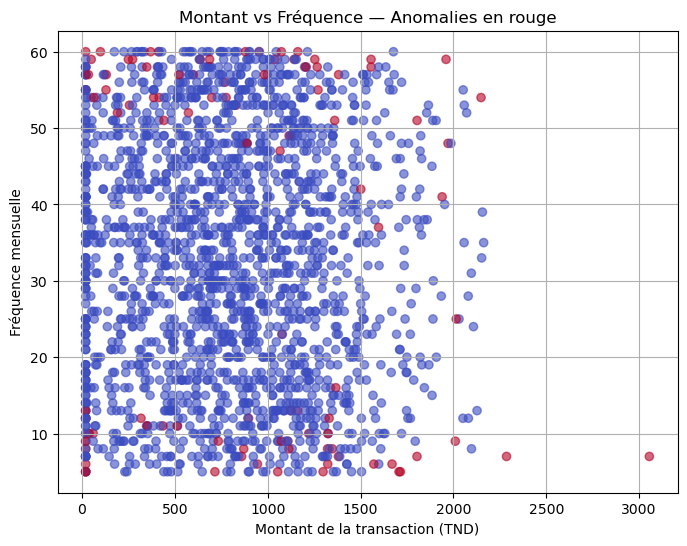

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df['montant'], df['frequence'], c=df['is_anomaly'], cmap='coolwarm', alpha=0.6)
plt.xlabel("Montant de la transaction (TND)")
plt.ylabel("Fréquence mensuelle")
plt.title("Montant vs Fréquence — Anomalies en rouge")
plt.grid(True)
plt.show()


In [19]:
print("Nombre d'anomalies détectées :", df['is_anomaly'].sum())


Nombre d'anomalies détectées : 100
